# Try Li Plating Sub Models

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
fig_DIR = "../figures/figures_model/"
res_DIR = "../data/results_model/"
# %matplotlib widget

In [2]:
parameter_values = get_parameter_values()

In [3]:
model1 = pybamm.lithium_ion.DFN(
    {
        "lithium plating": "irreversible",
    }
    
)
model2 = pybamm.lithium_ion.SPMe()
param = model1.param

In [4]:
cell = 4
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,model1,parameter_values)
print(Temp)

25


In [5]:
parameter_values.update(
    {
      "Negative electrode active material volume fraction": eps_n_data,
      "Positive electrode active material volume fraction": eps_p_data,
      "Typical electrolyte conductivity [m2.s-1]": 1.3,
      "Typical electrolyte diffusivity [m2.s-1]": 1*5.35E-10,
      "Lithium plating kinetic rate constant [m.s-1]": 1e-9,

    },
    check_already_exists=False,
)

In [6]:
parameter_values.search('electrolyte')

EC initial concentration in electrolyte [mol.m-3]	4541.0
Electrolyte conductivity [S.m-1]	<function electrolyte_conductivity_PeymanMPM at 0x0000013E24F77700>
Electrolyte diffusivity [m2.s-1]	<function electrolyte_diffusivity_PeymanMPM at 0x0000013E24F77550>
Initial concentration in electrolyte [mol.m-3]	1000.0
Negative electrode Bruggeman coefficient (electrolyte)	1.5
Positive electrode Bruggeman coefficient (electrolyte)	1.5
Separator Bruggeman coefficient (electrolyte)	1.5
Typical electrolyte concentration [mol.m-3]	1000.0
Typical electrolyte conductivity [m2.s-1]	1.3
Typical electrolyte diffusivity [m2.s-1]	5.35e-10


In [7]:
# c_rate_d = '2C'
# c_rate_c = '1.5C'
c_rate_c ='C/5'
SOC_0 = 0

In [8]:
# pybamm.set_logging_level("WARNING")
pybamm.set_logging_level("NOTICE")
# pybamm.set_logging_level("INFO")
# pybamm.set_logging_level("VERBOSE")
# pybamm.set_logging_level("SPAM")
experiment = pybamm.Experiment(
    [
        (
        #  "Rest for 10 minutes", 
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
        #  "Rest for 20 minutes",
         )
    ],
    termination="50% capacity",
#     cccv_handling="ode",
)

# experiment = pybamm.Experiment(
#     [
#         (
#          "Charge at "+c_rate_c+" until 4.2V", 
#          "Hold at 4.2V until C/50",
#          "Rest for 5 min",
#          "Discharge at "+c_rate_d+" until 3V",
#          )
#     ],
#     termination="50% capacity",
# #     cccv_handling="ode",
# )
# SOC_0 = 0 

In [9]:
sim_long = pybamm.Simulation(model1, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution1 = sol_long

2022-12-20 10:43:11.734 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1 (13.093 ms elapsed) --------------------
2022-12-20 10:43:11.735 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 1/2: Charge at C/5 until 4.2V
2022-12-20 10:43:13.730 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 2/2: Hold at 4.2V until C/50
2022-12-20 10:43:14.205 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.600 Ah (originally 4.600 Ah, will stop at 2.300 Ah)
2022-12-20 10:43:14.206 - [NOTICE] callbacks.on_experiment_end(222): Finish experiment simulation, took 2.484 s


In [10]:
c_rate_c ='1.5C'
# c_rate_c ='C/5'
# parameter_values.update(
#     {
#       "Negative electrode active material volume fraction": eps_n_data,
#       "Positive electrode active material volume fraction": eps_p_data,
#       "Typical electrolyte conductivity [m2.s-1]": 1.3,
#       "Typical electrolyte diffusivity [m2.s-1]": 0.5*5.35E-10,
#       "Lithium plating kinetic rate constant [m.s-1]": 1e-9,

#     },
#     check_already_exists=False,
# )
experiment = pybamm.Experiment(
    [
        (
        #  "Rest for 10 minutes",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
        #  "Rest for 20 minutes",
         )
    ],
    termination="50% capacity",
#     cccv_handling="ode",
)
# experiment = pybamm.Experiment(
#     [
#         (
#          "Charge at "+c_rate_c+" until 4.2V", 
#          "Hold at 4.2V until C/50",
#          "Rest for 5 min",
#          "Discharge at "+c_rate_d+" until 3V",
#          )
#     ],
#     termination="50% capacity",
# #     cccv_handling="ode",
# )
# SOC_0 = 0 

sim_long = pybamm.Simulation(model1, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution2 = sol_long

2022-12-20 10:43:15.410 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1 (13.566 ms elapsed) --------------------
2022-12-20 10:43:15.411 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 1/2: Charge at 1.5C until 4.2V
The linesearch algorithm failed with too small a step.
2022-12-20 10:43:16.184 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 2/2: Hold at 4.2V until C/50
2022-12-20 10:43:16.687 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.753 Ah (originally 4.753 Ah, will stop at 2.377 Ah)
2022-12-20 10:43:16.688 - [NOTICE] callbacks.on_experiment_end(222): Finish experiment simulation, took 1.290 s


In [11]:
c_rate_c ='5C'
# c_rate_c ='1.5C'
# c_rate_c ='C/5'
# parameter_values.update(
#     {
#       "Negative electrode active material volume fraction": eps_n_data,
#       "Positive electrode active material volume fraction": eps_p_data,
#       "Typical electrolyte conductivity [m2.s-1]": 0.75*1.3,
#       "Typical electrolyte diffusivity [m2.s-1]": 1*5.35E-10,
#       "Lithium plating kinetic rate constant [m.s-1]": 1e-9,

#     },
#     check_already_exists=False,
# )
experiment = pybamm.Experiment(
    [
        (
        #  "Rest for 10 minutes",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
        #  "Rest for 20 minutes",
         )
    ],
    termination="50% capacity",
#     cccv_handling="ode",
)
# experiment = pybamm.Experiment(
#     [
#         (
#          "Charge at "+c_rate_c+" until 4.2V", 
#          "Hold at 4.2V until C/50",
#          "Rest for 5 min",
#          "Discharge at "+c_rate_d+" until 3V",
#          )
#     ],
#     termination="50% capacity",
# #     cccv_handling="ode",
# )
# SOC_0 = 0 

sim_long = pybamm.Simulation(model1, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution3 = sol_long

2022-12-20 10:43:18.195 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1 (18.154 ms elapsed) --------------------
2022-12-20 10:43:18.196 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 1/2: Charge at 5C until 4.2V
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
2022-12-20 10:43:19.246 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 2/2: Hold at 4.2V until C/50
2022-12-20 10:43:20.546 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.738 Ah (originally 4.738 Ah, will stop at 2.369 Ah)
2022-12-20 10:43:20.547 - [NOTICE] callbacks.on_experiment_end(222): Finish experiment simulation, took 2.368 s


In [12]:
# solution1.plot()

In [13]:
model1.variables.search("plating")

Lithium plating concentration
Lithium plating concentration [mol.m-3]
Lithium plating interfacial current density
Lithium plating interfacial current density [A.m-2]
Lithium plating thickness
Lithium plating thickness [m]
Loss of capacity to lithium plating [A.h]
Loss of lithium to lithium plating [mol]
Negative electrode lithium plating interfacial current density
Negative electrode lithium plating interfacial current density [A.m-2]
Negative electrode lithium plating reaction overpotential
Negative electrode lithium plating reaction overpotential [V]
Negative electrode lithium plating volumetric interfacial current density
Negative electrode lithium plating volumetric interfacial current density [A.m-3]
Positive electrode lithium plating interfacial current density
Positive electrode lithium plating interfacial current density [A.m-2]
Positive electrode lithium plating volumetric interfacial current density
X-averaged lithium plating concentration
X-averaged lithium plating concentra

In [14]:
ln = np.linspace(0,1,20)

In [15]:
t = solution1["Time [s]"].entries
c_e = solution1["Negative electrolyte concentration [mol.m-3]"].entries
phi_e = solution1["Negative electrolyte potential [V]"].entries
eta_pl = solution1["Negative electrode lithium plating reaction overpotential [V]"].entries
j_pl = solution1["Negative electrode lithium plating interfacial current density [A.m-2]"].entries

1.0


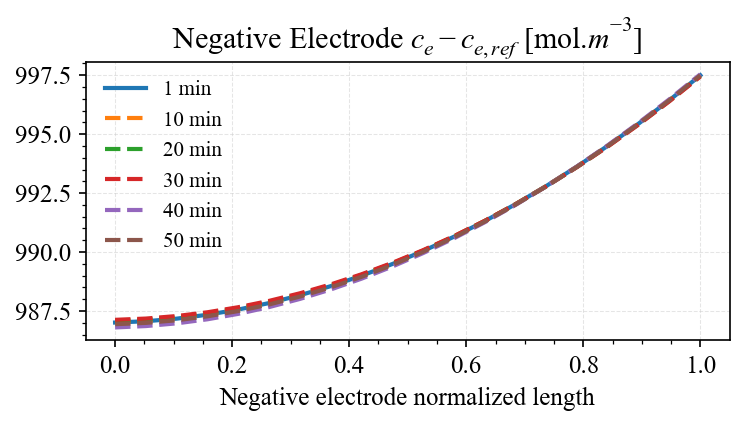

In [16]:
n = 1
print(t[n]/60)
y1 = c_e[:,n]
n = 10
y2 = c_e[:,n]
n = 20
y3 = c_e[:,n]
n = 30
y4 = c_e[:,n]
n = 40
y5 = c_e[:,n]
n = 50
y6 = c_e[:,n]
fig, ax1 = plt.subplots(1, 1, figsize=(5,3))
ax1.plot(ln,y1)
ax1.plot(ln,y2,'--')
ax1.plot(ln,y3,'--')
ax1.plot(ln,y4,'--')
ax1.plot(ln,y5,'--')
ax1.plot(ln,y6,'--')
ax1.set_title(r'Negative Electrode $c_e-c_{e,ref}$ [mol.$m^{-3}$]')
ax1.set_xlabel("Negative electrode normalized length")
ax1.legend(["1 min","10 min","20 min","30 min","40 min","50 min"])
# ax1.legend(['C/5','1.5 C'])
fig.tight_layout()
# plt.savefig(fig_DIR+'dfn_c_e_5'+'.png')

1.0


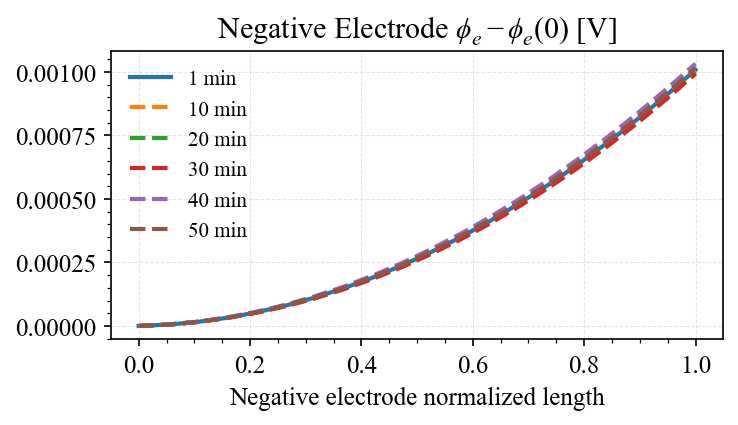

In [17]:
n = 1
print(t[n]/60)
y1 = phi_e[:,n]-phi_e[0,n]
n = 10
y2 = phi_e[:,n]-phi_e[0,n]
n = 20
y3 = phi_e[:,n]-phi_e[0,n]
n = 30
y4 = phi_e[:,n]-phi_e[0,n]
n = 40
y5 = phi_e[:,n]-phi_e[0,n]
n = 50
y6 = phi_e[:,n]-phi_e[0,n]
fig, ax1 = plt.subplots(1, 1, figsize=(5,3))
ax1.plot(ln,y1)
ax1.plot(ln,y2,'--')
ax1.plot(ln,y3,'--')
ax1.plot(ln,y4,'--')
ax1.plot(ln,y5,'--')
ax1.plot(ln,y6,'--')
ax1.set_title(r'Negative Electrode $\phi_e-\phi_{e}(0)$ [V]')
ax1.set_xlabel("Negative electrode normalized length")
ax1.legend(["1 min","10 min","20 min","30 min","40 min","50 min"])
# ax1.legend(['C/5','1.5 C'])
fig.tight_layout()
# plt.savefig(fig_DIR+'dfn_phi_e_5'+'.png')

1.0


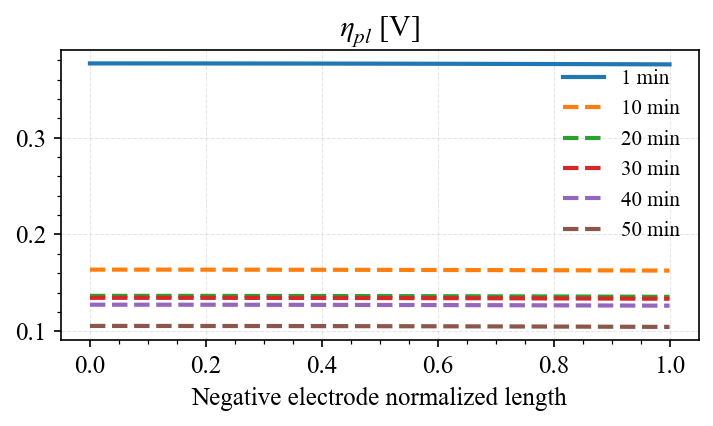

In [18]:
n = 1
print(t[n]/60)
y1 = eta_pl[:,n]
n = 10
y2 = eta_pl[:,n]
n = 20
y3 = eta_pl[:,n]
n = 30
y4 = eta_pl[:,n]
n = 40
y5 = eta_pl[:,n]
n = 50
y6 = eta_pl[:,n]
fig, ax1 = plt.subplots(1, 1, figsize=(5,3))
ax1.plot(ln,y1)
ax1.plot(ln,y2,'--')
ax1.plot(ln,y3,'--')
ax1.plot(ln,y4,'--')
ax1.plot(ln,y5,'--')
ax1.plot(ln,y6,'--')
# ax1.set_title(r'Negative Electrode $\phi_e-\phi_{e}(0)$ [V]')
ax1.set_title(r'$\eta_{pl}$ [V]')
ax1.set_xlabel("Negative electrode normalized length")
ax1.legend(["1 min","10 min","20 min","30 min","40 min","50 min"])
# ax1.legend(['C/5','1.5 C'])
fig.tight_layout()
plt.savefig(fig_DIR+'dfn_eta_pl_1'+'.png')

1.0


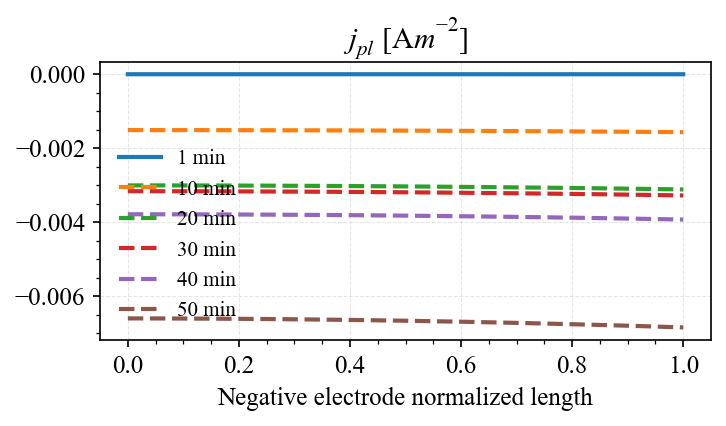

In [19]:
n = 1
print(t[n]/60)
y1 = j_pl[:,n]
n = 10
y2 = j_pl[:,n]
n = 20
y3 = j_pl[:,n]
n = 30
y4 = j_pl[:,n]
n = 40
y5 = j_pl[:,n]
n = 50
y6 = j_pl[:,n]
fig, ax1 = plt.subplots(1, 1, figsize=(5,3))
ax1.plot(ln,y1)
ax1.plot(ln,y2,'--')
ax1.plot(ln,y3,'--')
ax1.plot(ln,y4,'--')
ax1.plot(ln,y5,'--')
ax1.plot(ln,y6,'--')
ax1.set_title(r'$j_{pl}$ [A$m^{-2}]$')
ax1.set_xlabel("Negative electrode normalized length")
ax1.legend(["1 min","10 min","20 min","30 min","40 min","50 min"])
# ax1.legend(['C/5','1.5 C'])
fig.tight_layout()
plt.savefig(fig_DIR+'dfn_j_pl_1'+'.png')

In [20]:
t2 = solution2["Time [s]"].entries
c_e2 = solution2["Negative electrolyte concentration [mol.m-3]"].entries
phi_e2 = solution2["Negative electrolyte potential [V]"].entries

In [21]:
t3 = solution3["Time [s]"].entries
c_e3 = solution3["Negative electrolyte concentration [mol.m-3]"].entries
phi_e3 = solution3["Negative electrolyte potential [V]"].entries

In [27]:
t[2]

120.0

20.0


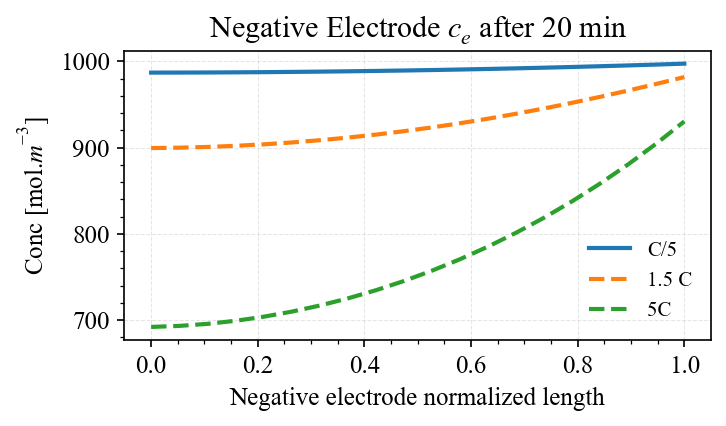

In [29]:
n = 20
print(t[n]/60)
y1 = c_e[:,n]
y2 = c_e2[:,n]
y3 = c_e3[:,n]
fig, ax1 = plt.subplots(1, 1, figsize=(5,3))
ax1.plot(ln,y1)
ax1.plot(ln,y2,'--')
ax1.plot(ln,y3,'--')
ax1.set_title(r'Negative Electrode $c_e$ after 20 min')
ax1.set_ylabel(r'Conc [mol.$m^{-3}$]')
ax1.set_xlabel("Negative electrode normalized length")
# ax1.legend(["Baseline","0.5 De","0.75 k_e"])
ax1.legend(['C/5','1.5 C','5C'])
fig.tight_layout()
plt.savefig(fig_DIR+'dfn_c_e_crate_2'+'.png')

20.0


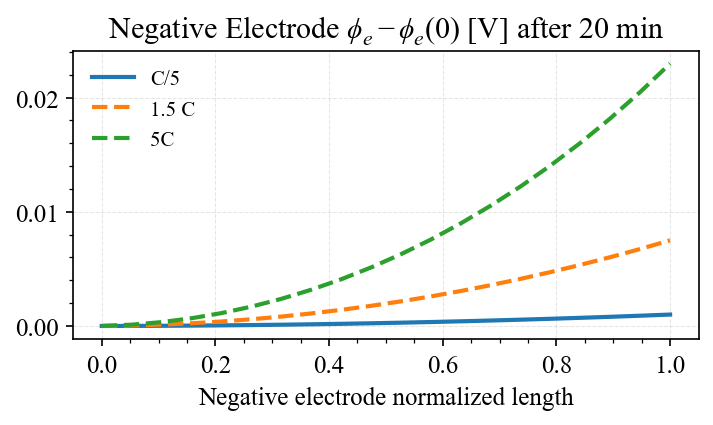

In [31]:
n = 20
print(t[n]/60)
y1 = phi_e[:,n]-phi_e[0,n]
n = 1
y2 = phi_e2[:,n]-phi_e2[0,n]
y3 = phi_e3[:,n]-phi_e3[0,n]
fig, ax1 = plt.subplots(1, 1, figsize=(5,3))
ax1.plot(ln,y1)
ax1.plot(ln,y2,'--')
ax1.plot(ln,y3,'--')
ax1.set_title(r'Negative Electrode $\phi_e-\phi_{e}(0)$ [V] after 20 min')
ax1.set_xlabel("Negative electrode normalized length")
# ax1.legend(["Baseline","0.5 De","0.75 k_e"])
ax1.legend(['C/5','1.5 C','5C'])
fig.tight_layout()
plt.savefig(fig_DIR+'dfn_phi_e_crate_2'+'.png')

In [22]:
dsfdsfdsf

NameError: name 'dsfdsfdsf' is not defined

In [ ]:
n = 1
print(t[n]/60)
y1 = c_e[:,n]
y2 = c_e2[:,n]
y3 = c_e3[:,n]
fig, ax1 = plt.subplots(1, 1, figsize=(5,3))
ax1.plot(ln,y1)
ax1.plot(ln,y2,'--')
ax1.plot(ln,y3,'--')
ax1.set_title(r'Negative Electrode $c_e-c_{e,ref}$ [mol.$m^{-3}$]')
ax1.set_xlabel("Negative electrode normalized length")
ax1.legend(["Baseline","0.5 De","0.75 k_e"])
# ax1.legend(['C/5','1.5 C'])
fig.tight_layout()
plt.savefig(fig_DIR+'dfn_c_e_6'+'.png')

In [ ]:
n = 1
print(t[n]/60)
y1 = phi_e[:,n]-phi_e[0,n]
n = 1
y2 = phi_e2[:,n]-phi_e2[0,n]
y3 = phi_e3[:,n]-phi_e3[0,n]
fig, ax1 = plt.subplots(1, 1, figsize=(5,3))
ax1.plot(ln,y1)
ax1.plot(ln,y2,'--')
ax1.plot(ln,y3,'--')
ax1.set_title(r'Negative Electrode $\phi_e-\phi_{e}(0)$ [V]')
ax1.set_xlabel("Negative electrode normalized length")
ax1.legend(["Baseline","0.5 De","0.75 k_e"])
# ax1.legend(['C/5','1.5 C'])
fig.tight_layout()
plt.savefig(fig_DIR+'dfn_phi_e_6'+'.png')